## Importing the Dependencies

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [5]:
import numpy as np
from helper_functions.helper_functions import show_img, gray_image, degradation_operator, convergence, generate_gaussian_kernel
from helper_functions.helper_functions import safe_psnr as psnr
from CNN.Image_Denoiser import Denoiser
import torch


## Importing the Image and the Models

C:\Users\lenonvo\AppData\Local\Temp\ipykernel_9508\1245784820.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

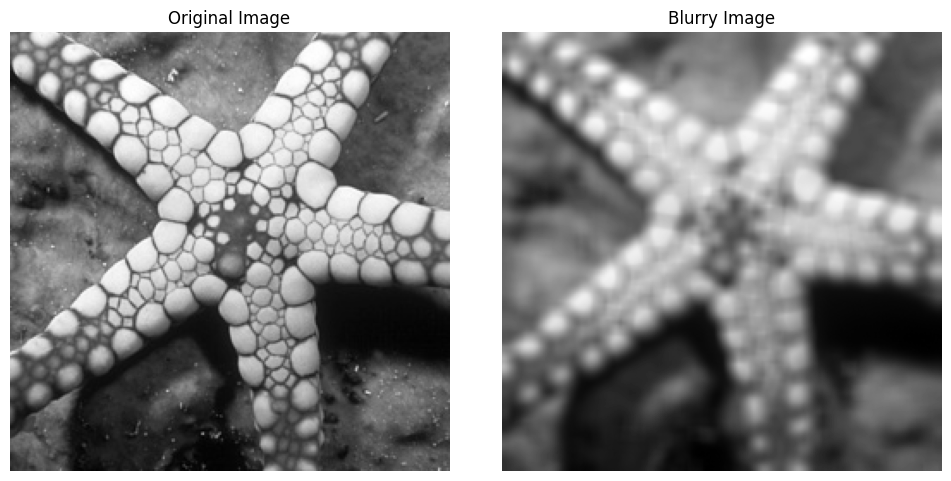

In [6]:
model_path = '../CNN/denoiser_model_with_bias.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Denoiser()  
model.load_state_dict(torch.load(model_path, map_location=device))

model_path_bf = '../CNN/denoiser_model_without_bias.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bf = Denoiser(use_bias=False)  
model_bf.load_state_dict(torch.load(model_path_bf, map_location=device))


img_path = '../test_images/starfish.tif'
original_img = gray_image(img_path)
kernel = generate_gaussian_kernel(kernel_size = 9, sigma_blur = 10)
degraded_img = degradation_operator(original_img, kernel)

noise_std = 0.001
noisy_img = degraded_img + noise_std * np.random.randn(*degraded_img.shape)
show_img(original_img, noisy_img,  titles= ['Original Image', 'Blurry Image'])

## Running the Algorithms

### ADMM with a Neural Network Denoiser Engine

#### Classic Neural Network Denoiser(with Bias)

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [03:12<00:00,  2.75s/it]


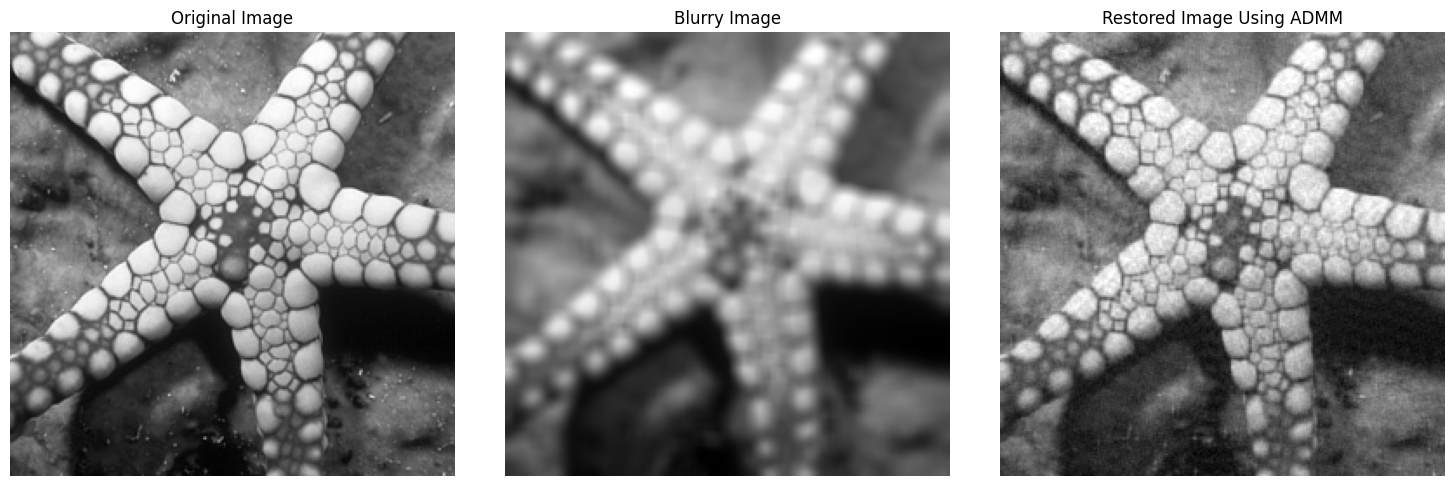

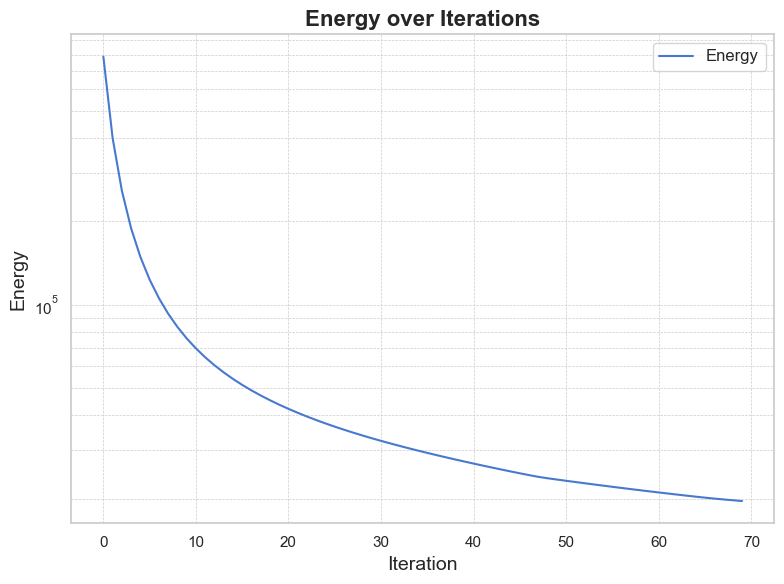

The original image psnr is :  inf dB
The noisy image psnr is :  21.660895039125585 dB
The reconstructed image psnr is :  28.70844987606576 dB


c:\Users\lenonvo\Desktop\UniV COURS\Project Image\helper_functions\helper_functions.py:114: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  return psnr(image_true, image_test, data_range=data_range)


In [7]:
N = 70       
m1 = 10       
m2 = 1         
lambd = 0.01     
beta = 0.05     
sigma = 0.001
tol=1e-2

from ADMM_NN import RED_ADMM_Solver_NN

noisy_img = np.asarray(noisy_img)
red = RED_ADMM_Solver_NN(noisy_img, kernel, lambd, beta, sigma, N, m1, m2, model, tol)
restored_img_admm, energy_values = red.run()
show_img(original_img, noisy_img ,restored_img_admm, titles= ['Original Image', 'Blurry Image','Restored Image Using ADMM'])
convergence(energy_values)


print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_admm), "dB")

#### Bias Free Neural Network

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [02:37<00:00,  2.25s/it]


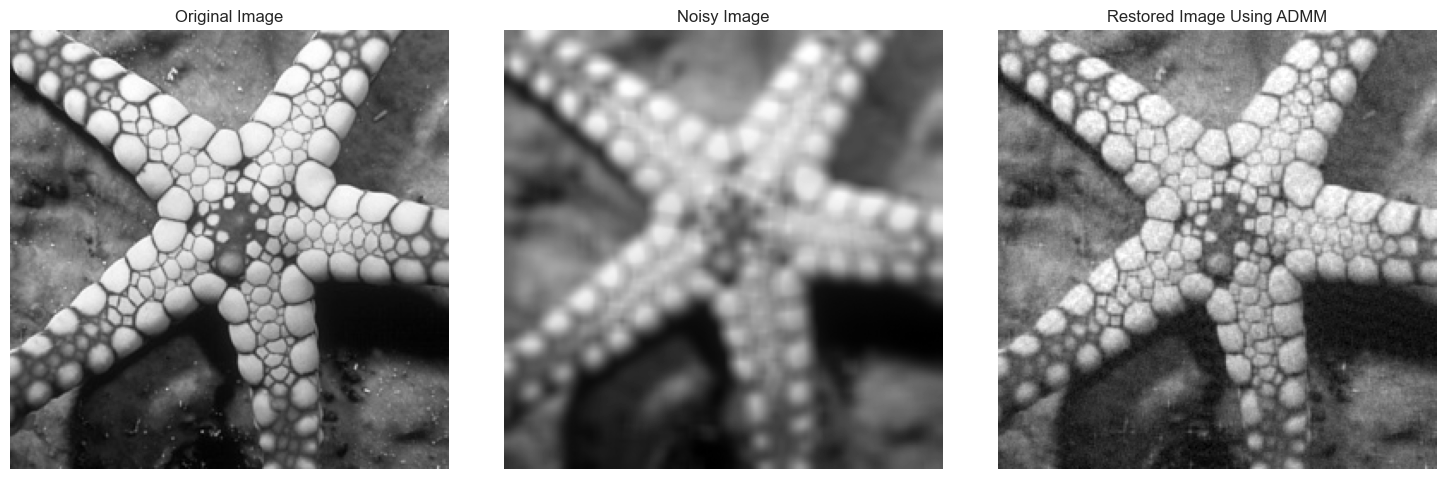

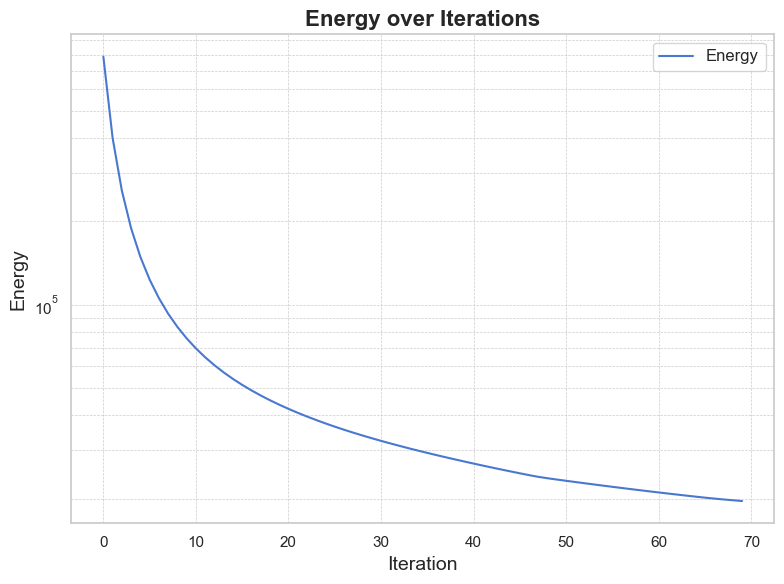

The original image psnr is :  inf dB
The noisy image psnr is :  21.660895039125585 dB
The reconstructed image psnr is :  28.708449813947684 dB


In [8]:
N = 70       
m1 = 10       
m2 = 1         
lambd = 0.01     
beta = 0.05     
sigma = 0.001
tol=1e-2

from ADMM_NN import RED_ADMM_Solver_NN

noisy_img = np.asarray(noisy_img)
red = RED_ADMM_Solver_NN(noisy_img, kernel, lambd, beta, sigma, N, m1, m2, model_bf, tol)
restored_img_admm, energy_values = red.run()
show_img(original_img, noisy_img ,restored_img_admm, titles= ['Original Image', 'Noisy Image','Restored Image Using ADMM'])
convergence(energy_values)


print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_admm), "dB")

### Fixed Point with a Neural Network Denoiser Engine 

#### Classic Neural Network(with Bias)

100%|██████████| 50/50 [03:28<00:00,  4.17s/it]


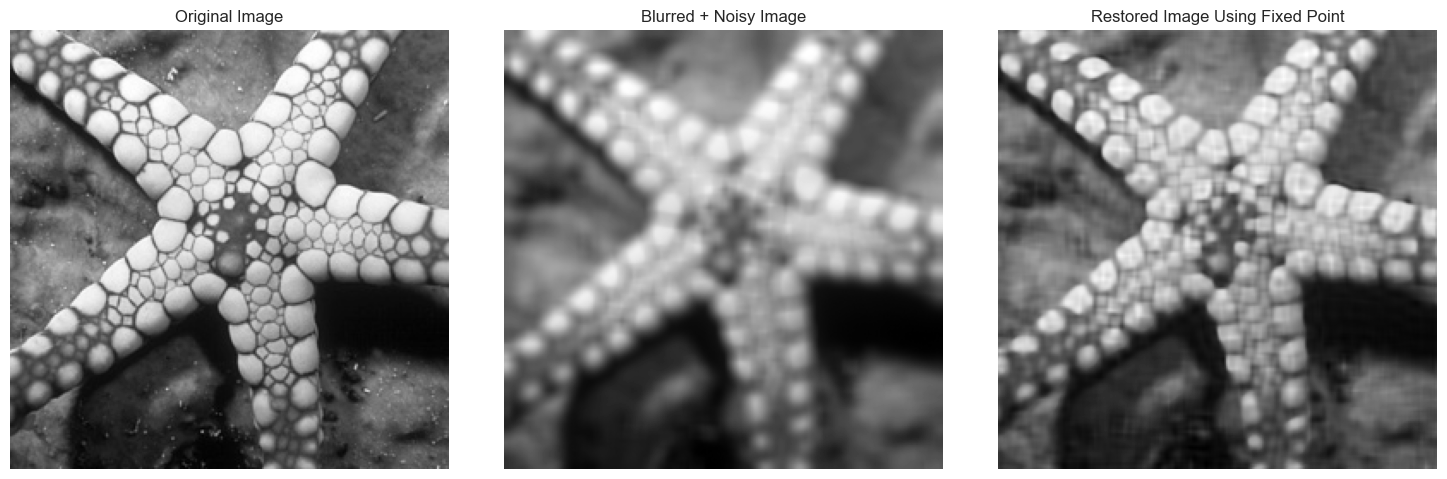

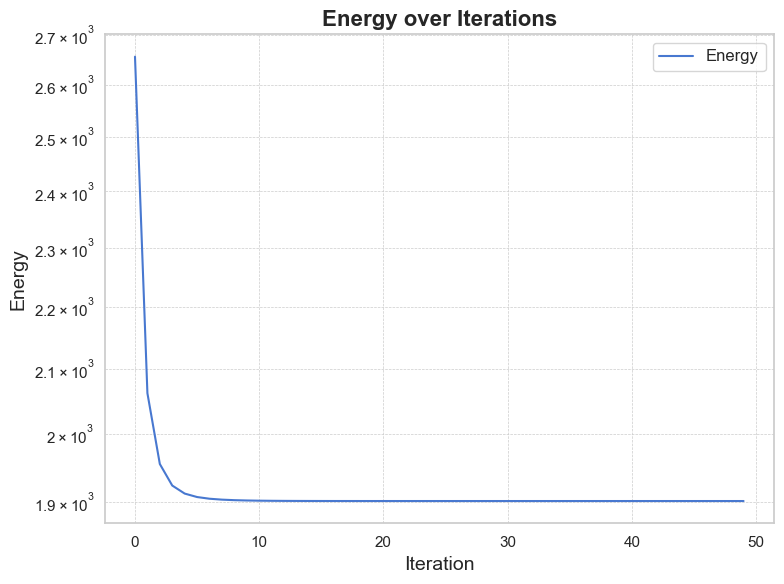

The original image psnr is :  inf dB
The noisy image psnr is :  21.660895039125585 dB
The reconstructed image psnr is :  25.631686111707538 dB


In [9]:
sigma = 0.01  
lambda_ = 0.01  
N = 50  
m = 30

from Fixed_Point_NN import fixed_point_red_NN

restored_img_fixed, energy_values = fixed_point_red_NN(
    y = noisy_img,
    kernel= kernel,
    sigma = sigma,
    lambda_= lambda_,
    N = N,
    m = m,
    model = model,
    tol=1e-10

)



show_img(original_img, noisy_img ,restored_img_fixed, titles= ['Original Image', 'Blurred + Noisy Image','Restored Image Using Fixed Point'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_fixed), "dB")

#### Bias Free Neural Network

  0%|          | 0/100 [00:00<?, ?it/s]

 44%|████▍     | 44/100 [02:52<03:39,  3.92s/it]

Converged at iteration 45 with tolerance 1e-06.


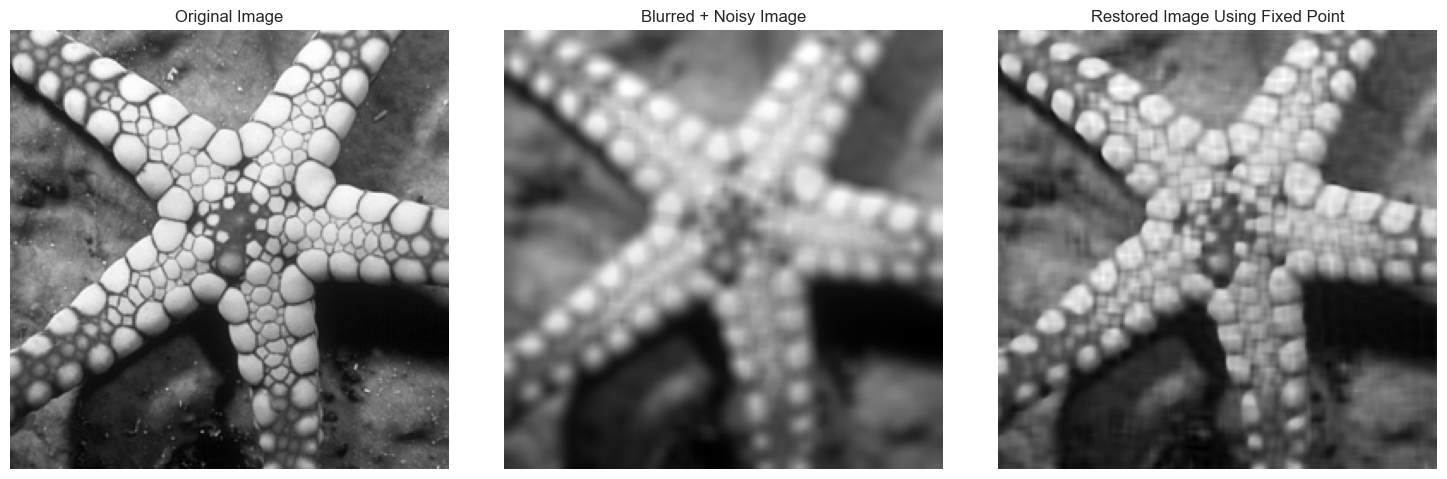

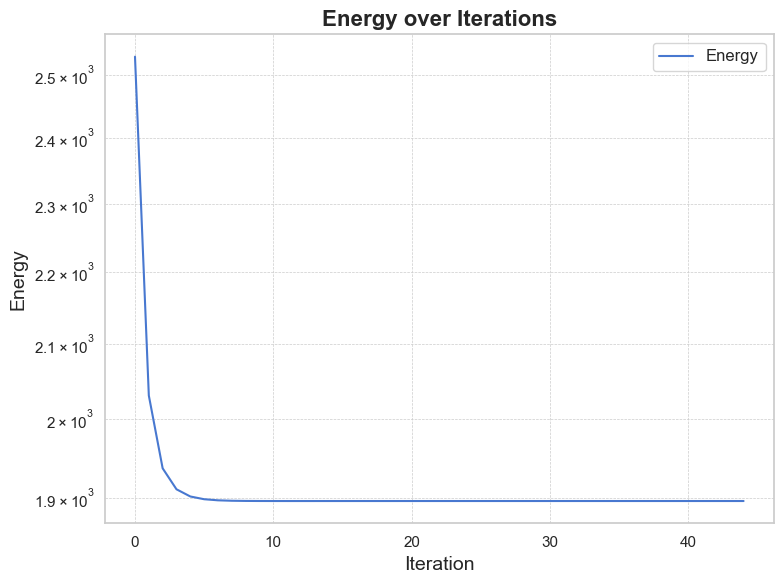

The original image psnr is :  inf dB
The noisy image psnr is :  21.660895039125585 dB
The reconstructed image psnr is :  25.654798178218982 dB


In [10]:
sigma = 0.01  
lambda_ = 0.01  
N = 100  
m = 30

from Fixed_Point_NN import fixed_point_red_NN

restored_img_fixed, energy_values = fixed_point_red_NN(
    y = noisy_img,
    kernel= kernel,
    sigma = sigma,
    lambda_= lambda_,
    N = N,
    m = m,
    model = model_bf
)



show_img(original_img, noisy_img ,restored_img_fixed, titles= ['Original Image', 'Blurred + Noisy Image','Restored Image Using Fixed Point'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_fixed), "dB")

### Steepest Descent with a Neural Network Denoiser Engine

#### Classic Neural Network(with Bias)

100%|██████████| 500/500 [01:51<00:00,  4.47it/s]


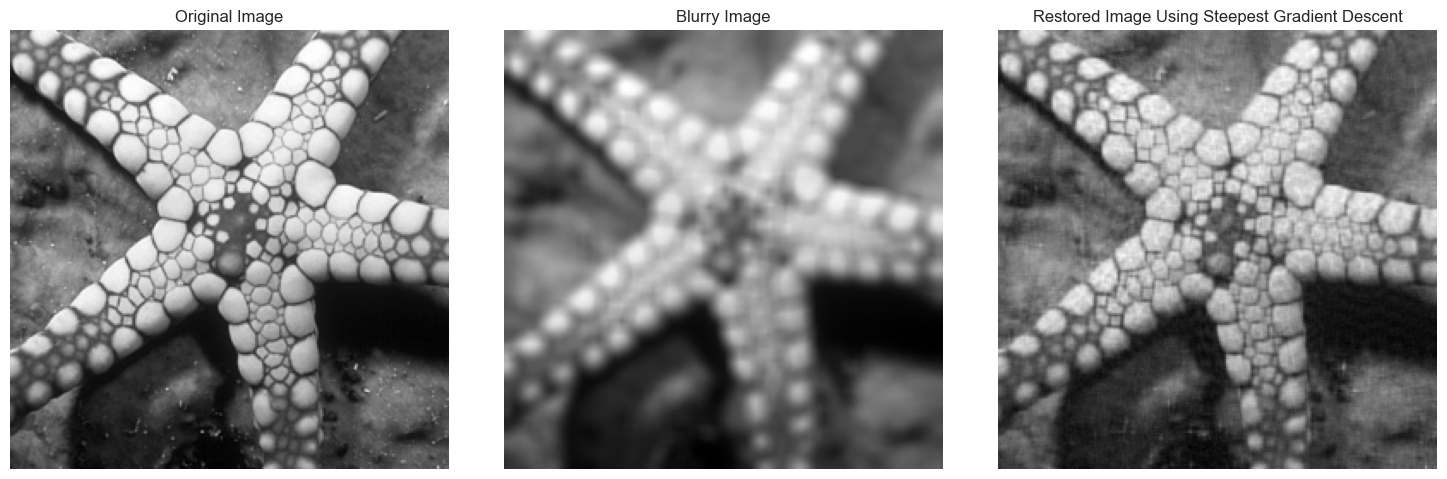

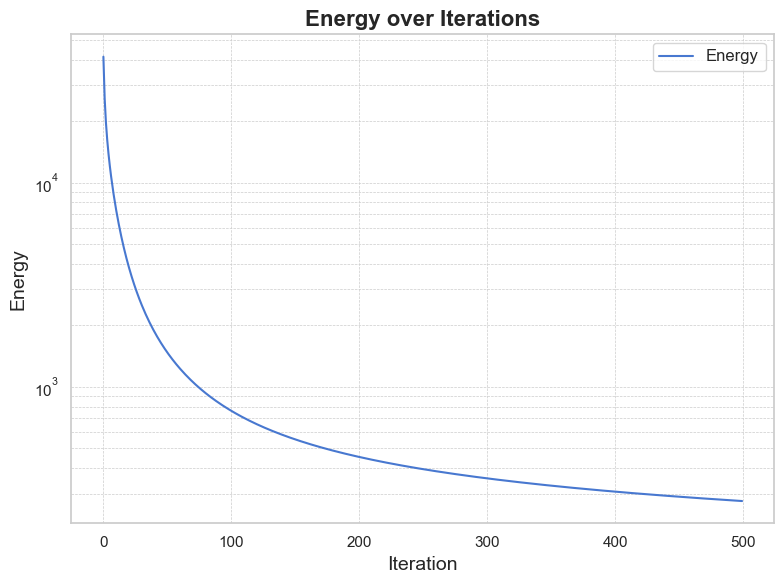

The original image psnr is :  inf dB
The noisy image psnr is :  21.660895039125585 dB
The reconstructed image psnr is :  28.264693485337244 dB


In [11]:
sigma = 0.01  
lambda_ = 0.01  
num_iterations = 500  
sigma_denoise = 0.001 

from Steepest_Descent_NN import steepest_descent_red_NN


restored_img_sg, energy_values = steepest_descent_red_NN(
        y=noisy_img,
        kernel= kernel,
        sigma=sigma,
        lambda_= lambda_,
        num_iterations=num_iterations,
        model = model,
        tol= 1e-6
    )

show_img(original_img, noisy_img ,restored_img_sg, titles= ['Original Image', 'Blurry Image','Restored Image Using Steepest Gradient Descent'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_sg), "dB")

#### Bias Free Neural Networks

100%|██████████| 500/500 [01:52<00:00,  4.43it/s]


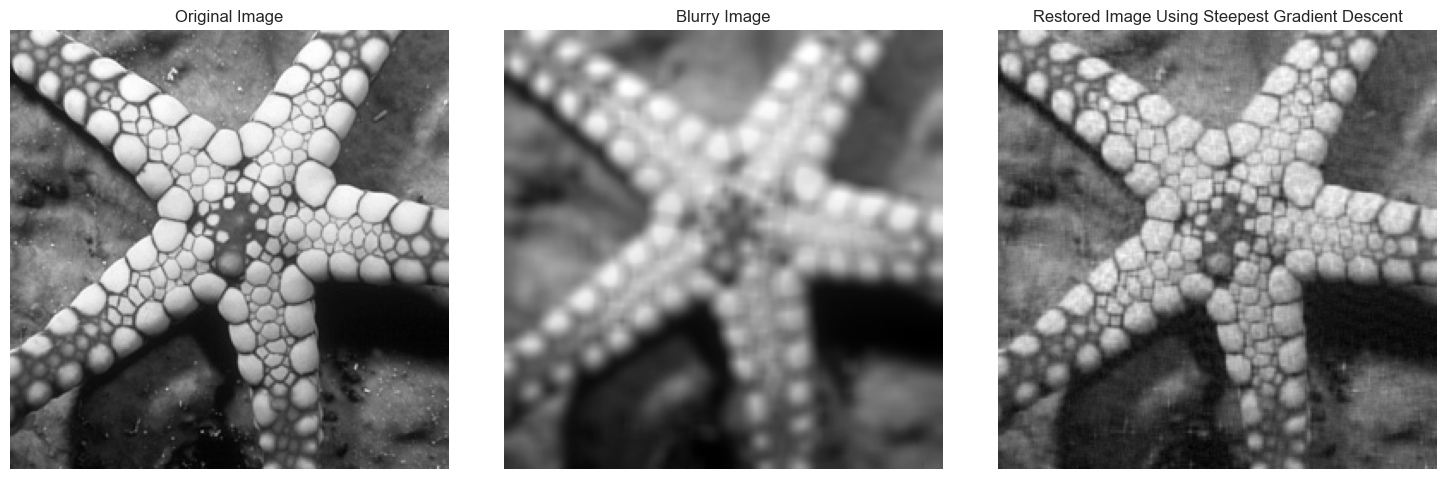

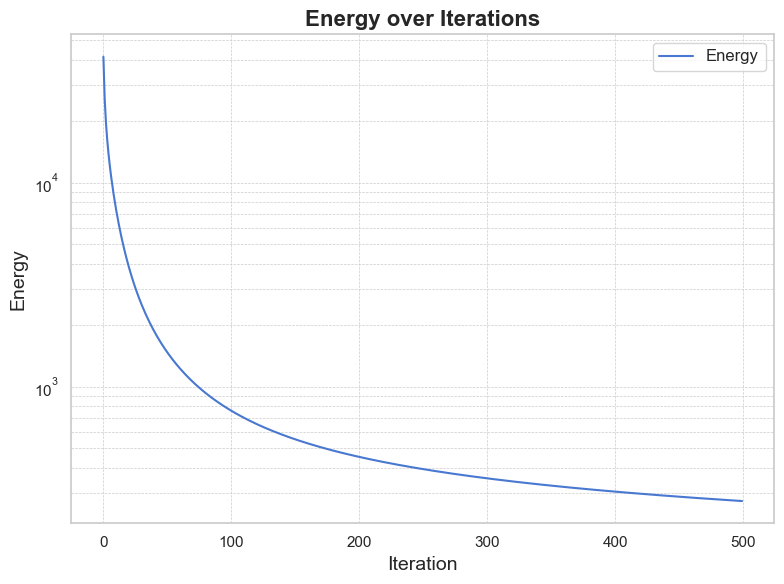

The original image psnr is :  inf dB
The noisy image psnr is :  21.660895039125585 dB
The reconstructed image psnr is :  28.264692130367592 dB


In [12]:
sigma = 0.01  
lambda_ = 0.01  
num_iterations = 500  
sigma_denoise = 0.001 

from Steepest_Descent_NN import steepest_descent_red_NN

restored_img_sg, energy_values = steepest_descent_red_NN(
        y=noisy_img,
        kernel= kernel,
        sigma=sigma,
        lambda_= lambda_,
        num_iterations=num_iterations,
        model = model_bf,
        tol= 1e-6
    )

show_img(original_img, noisy_img ,restored_img_sg, titles= ['Original Image', 'Blurry Image','Restored Image Using Steepest Gradient Descent'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_sg), "dB")

### Steepest Descent Accelerated with a Neural Network Denoiser Engine

#### Classic Neural Network(with Bias)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:33<00:00,  4.53it/s]


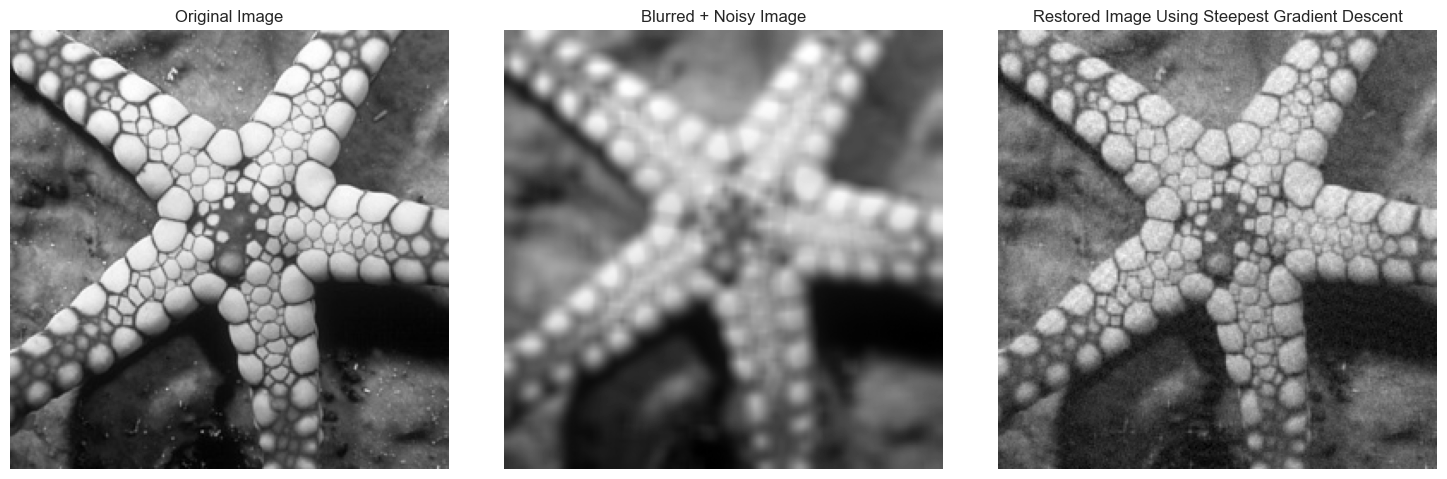

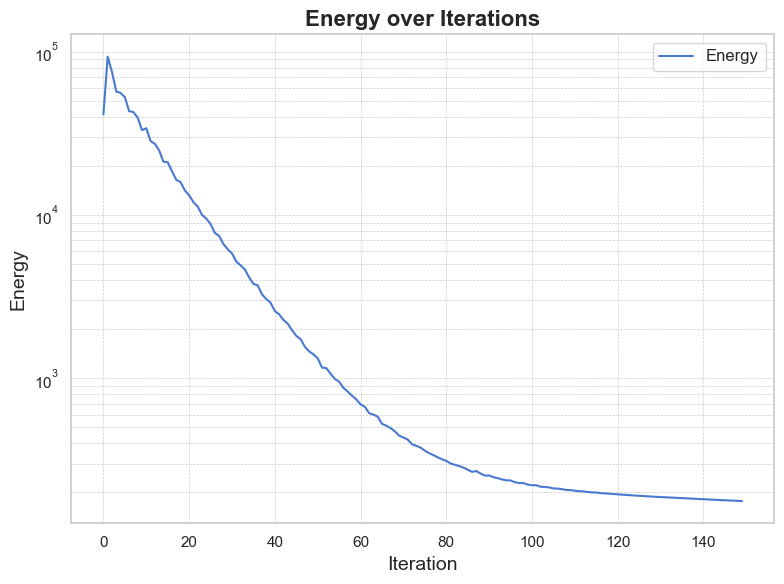

The original image psnr is :  inf dB
The noisy image psnr is :  21.660895039125585 dB
The reconstructed image psnr is :  28.58257892536202 dB


In [13]:
sigma = 0.01  
lambda_ = 0.01 
num_iterations = 150  
sigma_denoise = 0.001  

from AGD_NN import accelerated_steepest_descent_red_all_NN


restored_img_sg, energy_values = accelerated_steepest_descent_red_all_NN(
        y=noisy_img,
        kernel= kernel,
        sigma=sigma,
        lambda_= lambda_,
        num_iterations=num_iterations,
        model= model,
        tol= 1e-6
    )

show_img(original_img, noisy_img ,restored_img_sg, titles= ['Original Image', 'Blurred + Noisy Image','Restored Image Using Steepest Gradient Descent'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_sg), "dB")

#### Bias Free Neural Network

100%|██████████| 150/150 [00:34<00:00,  4.39it/s]


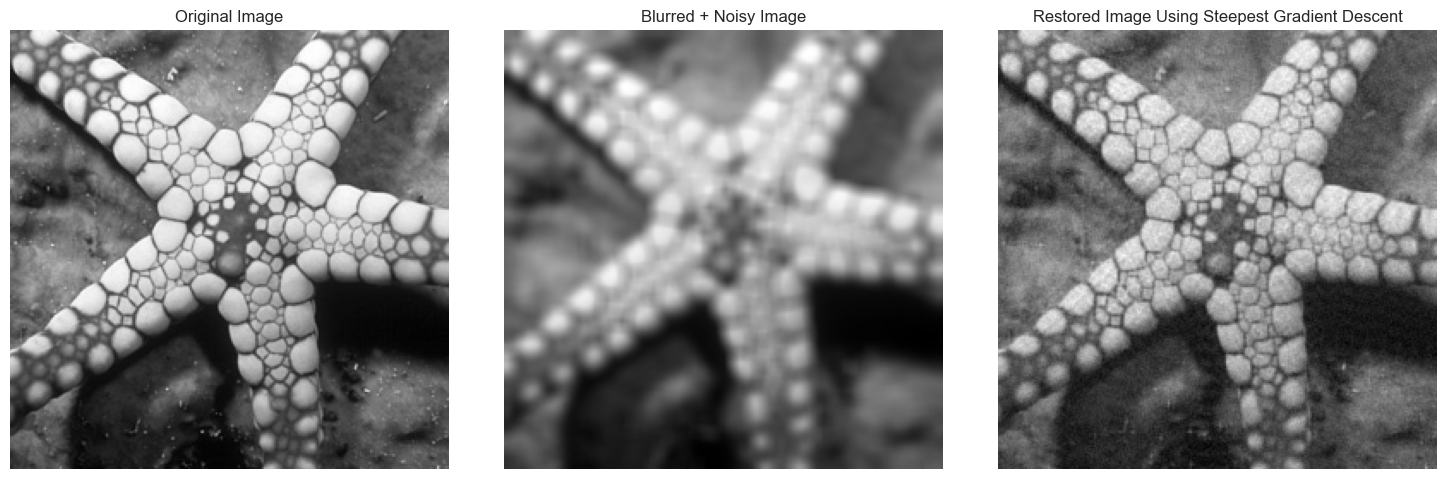

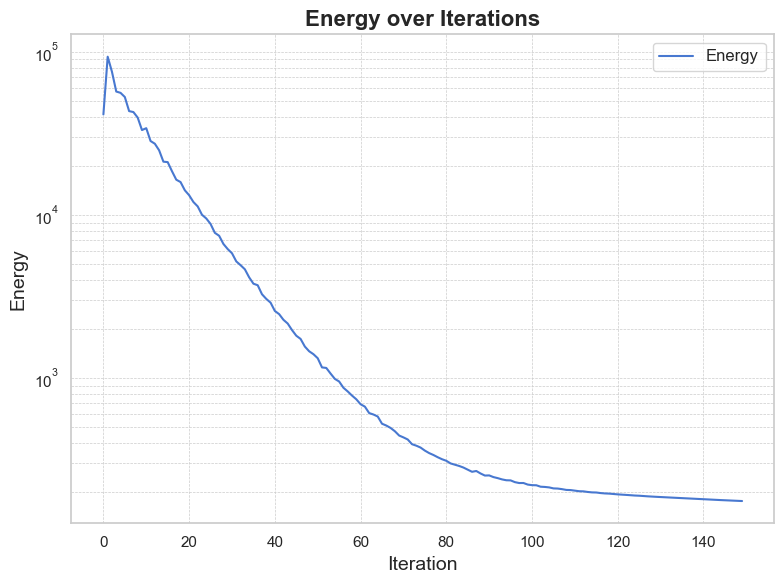

The original image psnr is :  inf dB
The noisy image psnr is :  21.660895039125585 dB
The reconstructed image psnr is :  28.582573326319483 dB


In [14]:
sigma = 0.01  
lambda_ = 0.01 
num_iterations = 150  
sigma_denoise = 0.001  

from AGD_NN import accelerated_steepest_descent_red_all_NN

restored_img_sg, energy_values = accelerated_steepest_descent_red_all_NN(
        y=noisy_img,
        kernel= kernel,
        sigma=sigma,
        lambda_= lambda_,
        num_iterations=num_iterations,
        model= model_bf,
        tol= 1e-6
    )

show_img(original_img, noisy_img ,restored_img_sg, titles= ['Original Image', 'Blurred + Noisy Image','Restored Image Using Steepest Gradient Descent'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_sg), "dB")